In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
!pip install yfinance --upgrade --no-cache-dir

Requirement already up-to-date: yfinance in /usr/local/lib/python3.6/dist-packages (0.1.54)


In [29]:
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()
df_full = pdr.get_data_yahoo("GOOGL", start="2013-01-01",end="2017-12-31").reset_index()
df_full.to_csv('GOOGL.csv',index=False)


[*********************100%***********************]  1 of 1 downloaded


In [30]:
df_full = pd.read_csv('GOOGL.csv')
df_full.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,360.070068,363.863861,358.633636,361.987000,361.987000,5077500
1,2013-01-03,362.827820,366.331329,360.720734,362.197205,362.197205,4631700
2,2013-01-04,365.035034,371.106110,364.204193,369.354340,369.354340,5521400
3,2013-01-07,368.093079,370.060059,365.655670,367.742737,367.742737,3308000
4,2013-01-08,368.138153,368.518524,362.577576,367.017029,367.017029,3348800


In [31]:
len(df_full)

1259

## Evolution Strategy Agent

In [0]:
def get_state(data, t, n):
    d = t - n 
    block = data[d : t ] if d >= 0 else -d * [data[0]] + data[0 : t]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

In [0]:
df = df_full.copy()
close = df.Close.values.tolist()

### Manually Defined 
window_size = 20
skip = 1
l = len(close) - 1


class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        rewards_epochs_list = []
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            rewards_epochs_list.append(self.reward_function(self.weights))
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, rewards_epochs_list[-1])
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')
        return rewards_epochs_list

class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        return decision

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [0]:
class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(self, model, money, max_buy, max_sell, data=close):
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.trend = data
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )
        self.dict_actions = {0:0,1:1,2:-1}

    def act(self, sequence):
        decision = self.model.predict(np.array(sequence))
        return np.argmax(decision[0])

    def get_reward(self, weights):
        self.model.weights = weights
        state = get_state(self.trend, 1, window_size + 1)
        reward_list = []
        for t in range(1, len(self.trend)-1, skip):
            action = self.act(state)
            next_state = get_state(self.trend, t + 1, window_size + 1)
            reward = self.dict_actions[int(action)] * (np.log(self.trend[t]) - np.log(self.trend[t-1]))
            reward_list.append(reward)
            state = next_state
        return np.sum(reward_list)

    def fit(self, iterations, checkpoint):
        return self.es.train(iterations, print_every = checkpoint)
        

In [0]:
train_data = close[:750]
val_data = close[750:]

In [47]:
model = Model(window_size, 500, 3)
agent = Agent(model, 10000, 5, 5, train_data)
rewards = agent.fit(500, 10)

iter 10. reward: 0.462997
iter 20. reward: 0.786569
iter 30. reward: 1.012365
iter 40. reward: 0.921564
iter 50. reward: 0.869887
iter 60. reward: 0.988768
iter 70. reward: 1.018416
iter 80. reward: 1.193915
iter 90. reward: 1.520149
iter 100. reward: 1.627063
iter 110. reward: 1.865810
iter 120. reward: 1.915502
iter 130. reward: 2.028202
iter 140. reward: 1.942488
iter 150. reward: 2.211115
iter 160. reward: 2.135539
iter 170. reward: 2.173680
iter 180. reward: 2.223576
iter 190. reward: 2.254081
iter 200. reward: 2.190704
iter 210. reward: 2.204237
iter 220. reward: 2.303061
iter 230. reward: 2.198408
iter 240. reward: 2.399837
iter 250. reward: 2.271624
iter 260. reward: 2.372710
iter 270. reward: 2.217541
iter 280. reward: 2.183439
iter 290. reward: 2.373263
iter 300. reward: 2.318152
iter 310. reward: 2.313977
iter 320. reward: 2.346053
iter 330. reward: 2.263475
iter 340. reward: 2.384837
iter 350. reward: 2.387042
iter 360. reward: 2.492827
iter 370. reward: 2.396518
iter 380. 

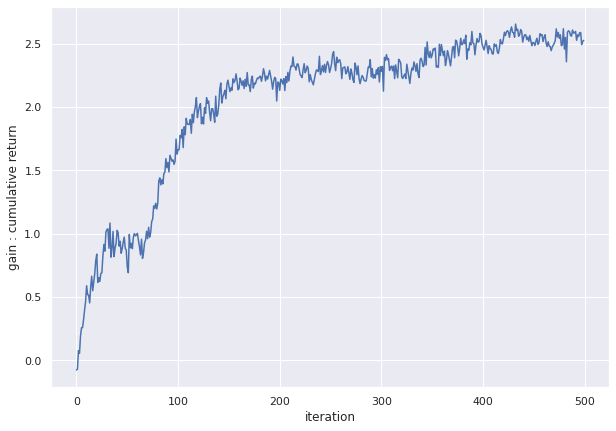

In [48]:
plt.figure(figsize=(10,7))
plt.plot(rewards)
plt.ylabel("gain : cumulative return")
plt.xlabel("iteration")
plt.show()

In [0]:
def agent_trade(agent, data):
    state = get_state(data, 1, window_size + 1)
    reward_list = []
    actions_list = []
    for t in range(1, len(data)-1, skip):
        action = agent.act(state)
        actions_list.append(int(action))
        next_state = get_state(data, t + 1, window_size + 1)
        reward = agent.dict_actions[int(action)] * (np.log(data[t]) - np.log(data[t-1]))
        reward_list.append(reward)
        state = next_state

    return reward_list, actions_list

## Trade on train data

In [0]:
rewards_list, actions_list = agent_trade(agent, data=train_data)

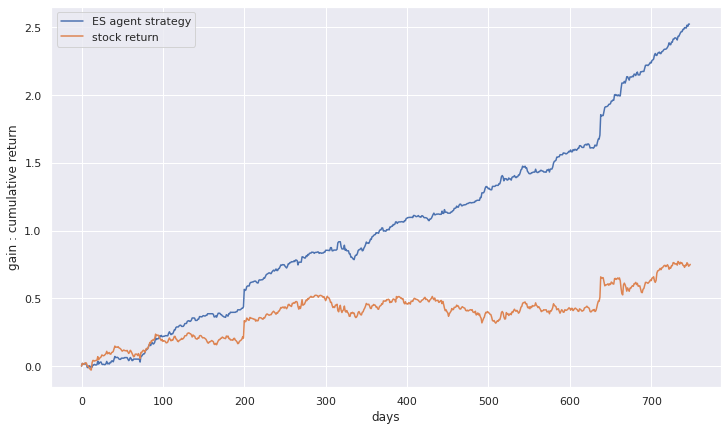

In [51]:
cumulative_strat_return = np.cumsum(rewards_list)
stock_return = [np.log(train_data[i+1])-np.log(train_data[i]) for i in range(len(train_data)-1)]
cumulative_stock_return = np.cumsum(stock_return)

plt.figure(figsize=(12,7))
plt.plot(cumulative_strat_return, label="ES agent strategy")
plt.plot(cumulative_stock_return, label="stock return")
plt.ylabel("gain : cumulative return")
plt.xlabel("days")
plt.legend()
plt.show()

## Trade on test data

In [0]:
rewards_list, actions_list = agent_trade(agent, data=val_data)

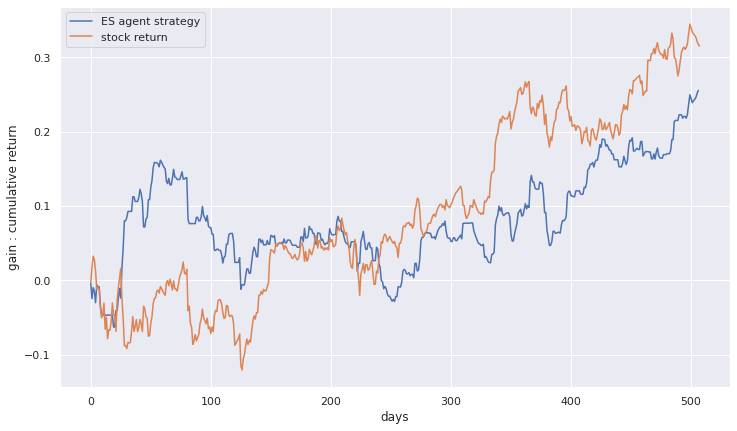

In [53]:
cumulative_strat_return = np.cumsum(rewards_list)
stock_return = [np.log(val_data[i+1])-np.log(val_data[i]) for i in range(len(val_data)-1)]
cumulative_stock_return = np.cumsum(stock_return)

plt.figure(figsize=(12,7))
plt.plot(cumulative_strat_return, label="ES agent strategy")
plt.plot(cumulative_stock_return, label="stock return")
plt.ylabel("gain : cumulative return")
plt.xlabel("days")
plt.legend()
plt.show()